In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization

In [95]:
data = pd.read_csv('/content/btc_1h.csv')

In [96]:
def calculate_rsi(data, column, window=14):
    close_prices = data[column]
    daily_returns = close_prices.diff(1)
    gains = daily_returns.where(daily_returns > 0, 0)
    losses = -daily_returns.where(daily_returns < 0, 0)

    avg_gain = gains.rolling(window=window, min_periods=1).mean()
    avg_loss = losses.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(data, column, slow=26, fast=12, signal=9):
    exp12 = data[column].ewm(span=fast, adjust=False).mean()
    exp26 = data[column].ewm(span=slow, adjust=False).mean()

    macd = exp12 - exp26
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line

    return macd, signal_line, macd_hist

# Calculate Stochastic Oscillator (KD)
def calculate_stochastic_oscillator(data, high, low, close, window=14, smooth_window=3):
    high_max = high.rolling(window=window, min_periods=1).max()
    low_min = low.rolling(window=window, min_periods=1).min()

    k = ((close - low_min) / (high_max - low_min)) * 100
    d = k.rolling(window=smooth_window, min_periods=1).mean()

    return k, d

# Calculate Momentum (MOM)
def calculate_momentum(data, column, window=15):
    return data[column].diff(window)

In [97]:
# Feature Engineering - Manual Calculation of Technical Indicators
data["rsi"] = calculate_rsi(data, "close", window=14)
data["macd"], data["macdsig"], data["macdhist"] = calculate_macd(data, "close", slow=40, fast=15, signal=9)
data["kdf"], data["kds"] = calculate_stochastic_oscillator(data, data["high"], data["low"], data["close"], window=14, smooth_window=3)
data["mom"] = calculate_momentum(data, "close", window=15)


In [98]:
# Define the trend based on your criteria
data["short_mom"] = data["rsi"].rolling(window=20, min_periods=1, center=False).mean()
data["long_mom"] = data["rsi"].rolling(window=80, min_periods=1, center=False).mean()
data["short_mov"] = data["close"].rolling(window=20, min_periods=1, center=False).mean()
data["long_mov"] = data["close"].rolling(window=100, min_periods=1, center=False).mean()

In [99]:
# Mark Labels
data['label'] = np.where(data.short_mov > data.long_mov, 1, 0)
data = data.drop(columns=["short_mov", "long_mov", "short_mom", "long_mom"])

In [100]:
data.set_index(data["datetime"], inplace=True)
data = data.fillna(method="pad", axis=0)
data = data.dropna(axis=0)
# del data["coid"]
# del data["mdate"]

In [101]:
data['label'][:20]

datetime
2018-01-01 20:30:00    0
2018-01-01 21:30:00    0
2018-01-01 22:30:00    0
2018-01-01 23:30:00    0
2018-01-02 00:30:00    0
2018-01-02 01:30:00    0
2018-01-02 02:30:00    0
2018-01-02 03:30:00    1
2018-01-02 04:30:00    0
2018-01-02 05:30:00    0
2018-01-02 06:30:00    0
2018-01-02 07:30:00    0
2018-01-02 08:30:00    0
2018-01-02 09:30:00    0
2018-01-02 10:30:00    0
2018-01-02 11:30:00    0
2018-01-02 12:30:00    0
2018-01-02 13:30:00    0
2018-01-02 14:30:00    0
2018-01-02 15:30:00    0
Name: label, dtype: int64

In [102]:
X = data.drop('label', axis=1)
X = X.drop('datetime', axis=1)
X[X.columns] = StandardScaler().fit_transform(X[X.columns])
y = pd.DataFrame({"label": data.label})

In [103]:
X

,open,high,low,close,volume,rsi,macd,macdsig,macdhist,kdf,kds,mom
datetime,,,,,,,,,,,,
2018-01-01 20:30:00,-0.313260,-0.310967,-0.313674,-0.311300,-0.847209,0.008465,-0.270413,-0.153640,-0.506420,-0.275845,-0.717315,-0.355539
2018-01-01 21:30:00,-0.311267,-0.315578,-0.322343,-0.324112,-0.874557,-0.537436,-0.333942,-0.192279,-0.615274,-1.108366,-0.646982,-0.237602
2018-01-01 22:30:00,-0.324079,-0.318253,-0.320452,-0.323888,-0.938172,-0.676345,-0.384059,-0.233602,-0.657996,-1.093824,-0.895903,-0.387374
2018-01-01 23:30:00,-0.324646,-0.315066,-0.323831,-0.317566,-0.930934,-0.831115,-0.398933,-0.269749,-0.575616,-0.683017,-1.043108,-0.347048
2018-01-02 00:30:00,-0.317533,-0.313155,-0.314449,-0.311671,-0.927434,-0.570346,-0.386048,-0.295991,-0.417904,-0.299948,-0.750841,-0.451190
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 01:30:00,1.046332,1.046566,1.050746,1.055909,-0.567286,-0.610043,0.157816,0.388483,-0.893762,-0.799563,-1.451663,-0.565903
2022-01-31 02:30:00,1.055960,1.047823,1.058664,1.058402,-0.642376,-0.776730,0.117706,0.335246,-0.847690,-0.627811,-1.161997,-0.461980
2022-01-31 03:30:00,1.058452,1.052992,1.066162,1.061578,-0.706257,-0.386683,0.095840,0.288113,-0.750497,-0.224254,-0.597132,-0.571086


In [104]:
split = int(len(data) * 0.7)
train_X = X.iloc[:split, :].copy()
test_X = X.iloc[split:].copy()
train_y = y.iloc[:split, :].copy()
test_y = y.iloc[split:].copy()


In [105]:
X_train, y_train, X_test, y_test = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)

In [106]:
X_train.shape,X_test.shape

((24954, 12), (10695, 12))

In [107]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = np.reshape(y_test, (X_test.shape[0], 1, 1))

In [108]:
# # Build the LSTM model
# regressor = Sequential()
# regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# regressor.add(BatchNormalization())
# regressor.add(Dropout(0.35))
# regressor.add(LSTM(units=32, return_sequences=True))
# regressor.add(Dropout(0.35))
# regressor.add(LSTM(units=32, return_sequences=True))
# regressor.add(Dropout(0.35))
# regressor.add(LSTM(units=32))
# regressor.add(Dropout(0.35))
# regressor.add(Dense(units=1, activation="sigmoid"))
# regressor.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [109]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define a new model
new_regressor = Sequential()
new_regressor.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
new_regressor.add(Dropout(0.3))
new_regressor.add(Dense(units=32, activation='relu'))
new_regressor.add(Dropout(0.3))
new_regressor.add(Dense(units=1, activation='sigmoid'))

# Compile the model
new_regressor.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
new_regressor.summary()

# Train the new model
new_train_history = new_regressor.fit(X_train, y_train, batch_size=200, epochs=100, verbose=2, validation_split=0.2)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1, 64)             832       
                                                                 
 dropout_10 (Dropout)        (None, 1, 64)             0         
                                                                 
 dense_11 (Dense)            (None, 1, 32)             2080      
                                                                 
 dropout_11 (Dropout)        (None, 1, 32)             0         
                                                                 
 dense_12 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
100/100 

In [110]:
new_regressor.evaluate(X_test, y_test, verbose=1)

335/335 [==============================] - 0s 980us/step - loss: 0.2730 - accuracy: 0.8921


[0.27296581864356995, 0.8920990824699402]

In [125]:
from tensorflow.keras.models import load_model
new_regressor.save('new_regressor__.h5')

In [112]:
# # Train the model
# train_history = regressor.fit(X_train, y_train, batch_size=200, epochs=100, verbose=2, validation_split=0.2)

In [113]:
# regressor.evaluate(X_test, y_test, verbose=1)

In [114]:
# from tensorflow.keras.models import load_model
# regressor.save('regressor.h5')

In [115]:
X_test.shape

(10695, 1, 12)

In [120]:
predict_x = new_regressor.predict(X_test)
# Reshape to 2D array
predict_x_2d = predict_x.reshape(-1, 1)
df_predict = pd.DataFrame(predict_x_2d, columns=["Buy"])
df_predict["Action"] = np.where(df_predict["Buy"] > 0.5, 0, 1)


335/335 [==============================] - 1s 1ms/step


In [121]:

result = pd.DataFrame({"Close": data.iloc[split:]["close"]})
result["Real"] = test_y["label"]
result["Predict"] = list(df_predict["Action"])
result["mdate"] = result.index
result['mdate'] = pd.to_datetime(result['mdate'], format='%Y/%m/%d')
result.set_index(result["mdate"], inplace=True)

<ipython-input-122-0a24db56d3e0>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot_date(t, y, 'b-', color='black')


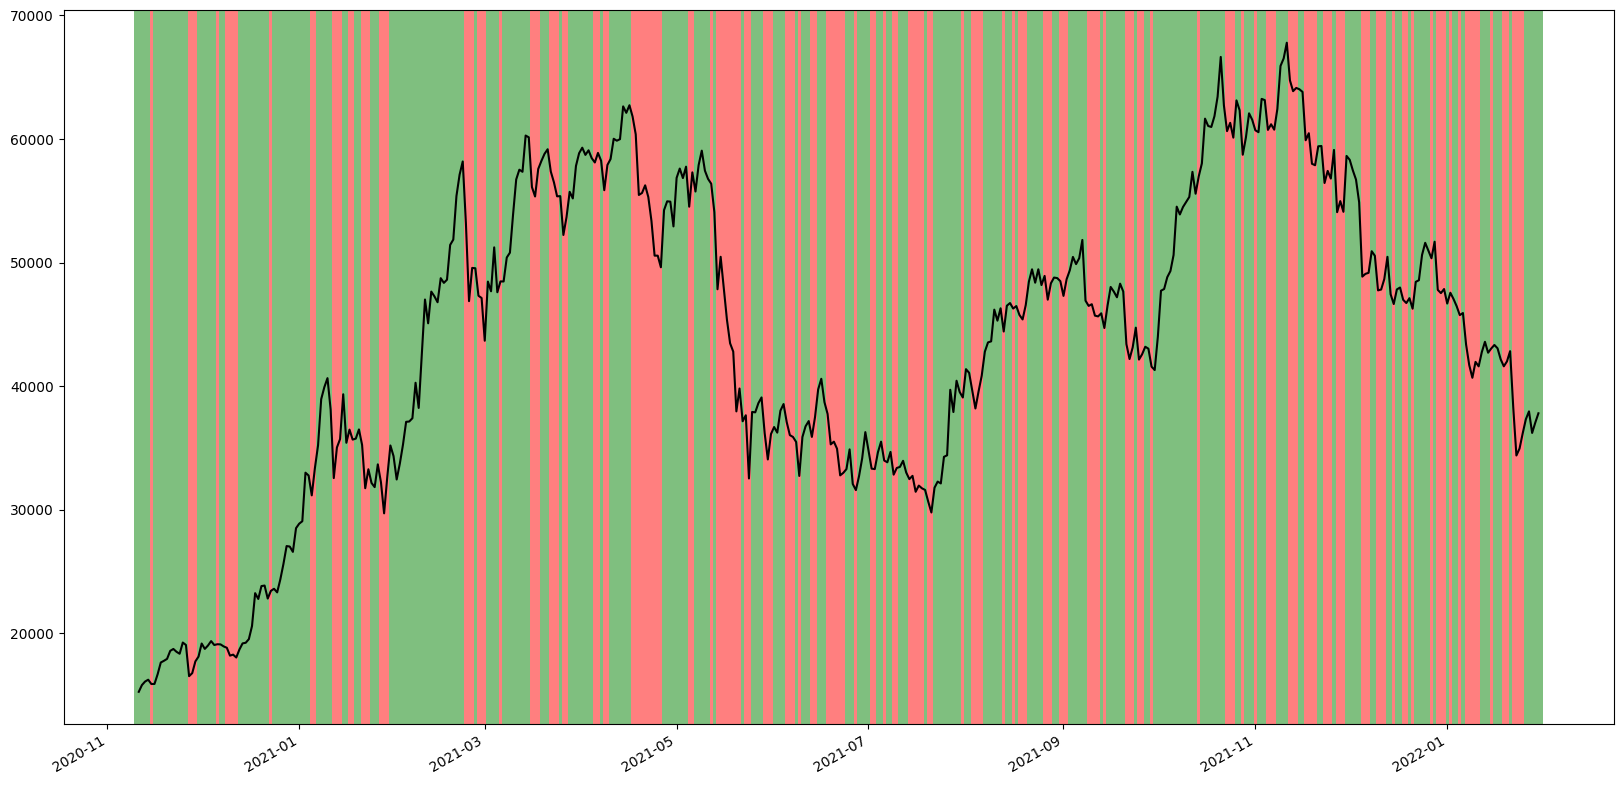

In [122]:
# Visualize predictions
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

df = result.copy()
df = df.resample('D').ffill()

t = mdates.drange(df.index[0], df.index[-1], dt.timedelta(hours=24))
y = np.array(df.Close[:-1])

fig, ax = plt.subplots()
ax.plot_date(t, y, 'b-', color='black')
for i in range(len(df)):
    if df.Predict[i] == 1:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor='red', edgecolor='none', alpha=0.5
        )
    else:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor='green', edgecolor='none', alpha=0.5
        )
fig.autofmt_xdate()
fig.set_size_inches(20, 10.5)

In [128]:
import pandas as pd
import numpy as np

# Assuming 'predictions_reshaped' is the array you received from model.predict()
# 'data' is your DataFrame
predictions_reshaped = new_regressor.predict(X_test).reshape(-1)

# Create DataFrame for predicted values
df_predict = pd.DataFrame(predictions_reshaped, columns=["Buy"])

# Example conditions for entering and exiting long positions (replace with your own logic)
data['entry_long'] = (
    (predictions_reshaped == 1)
).astype(int)

data['exit_long'] = (
    (predictions_reshaped == 0)
).astype(int)

# Assuming 'close' is the closing prices in your DataFrame
data['m_return'] = data['close'].pct_change()

# Calculate actual returns based on the signals
data['a_return'] = data['m_return'] * data['entry_long'].shift(1)
data['s_return'] = data['m_return'] * data['exit_long'].shift(1)

# Cumulative sum of returns
cumulative_returns = data[['m_return', 's_return', 'a_return']].cumsum()

# Print or visualize cumulative returns
print(cumulative_returns)

# Optionally, you can plot the cumulative returns
cumulative_returns.plot()


335/335 [==============================] - 0s 909us/step


ValueError: Length of values (10695) does not match length of index (35649)